Wybieramy temat. Może być to temat z pierwszego projektu. Jeśli pozostajemy przy tym 
samym temacie musimy znaleźć zmienną celu. 
2. Dokonujemy eksploracji zbioru. Uzupełniamy braki danych. Dokonujemy wstępnej selekcji 
zmiennych.   
3. Dzielimy zbiór danych na treningowy testowy i w miarę możliwości na walidacyjny. 
4. Tworzymy minimum 3 modele predykcyjne (może być ich więcej) wraz z dostrojeniem 
hiperparametrów. 
5. Porównać i wybrać najlepszy model. 
6. Dokonać ostatecznej oceny wybranego modelu na zbiorze walidacyjnym. 
7. Wskazać uzysk dla firmy / odbiorcy (np. ile pieniędzy z tego będzie miała, jak wdrożenie 
wpłynie na rozpoznawalność przypadków, dla których firma wykona działania prewencyjne 
itd.) 
8. Stworzenie aplikacji wykorzystującej model 
9. Na prezentacji powinna znaleźć się krótka analiza zmiennych, omówienie wyników 
wszystkich zastosowanych technik modelowania i ich porównanie, wybór modelu i przede 
wszystkim wartość dodana jaką niesie za sobą wdrożenie

4. Odejdzie  czy nie odejdzie?  – prognozowanie zjawiska churn wśród Klientów telecom  
• Prognozowanie czy jest zagrożenie, że Klient zrezygnuje z usług firmy 
• Aplikacja dla pracowników informująca o zagrożeniu odejścia Klienta 
• https://www.kaggle.com/blastchar/telco-customer-churn 
 


In [1]:
#Import libraries
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_selection import SelectKBest,mutual_info_classif, f_classif, RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV,validation_curve,cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,precision_score,recall_score,f1_score, roc_auc_score, make_scorer,roc_curve
from sklearn.preprocessing import StandardScaler,MinMaxScaler, Normalizer, LabelEncoder,OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import chi2
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

plt.rcParams["figure.figsize"] = (20,3) 

Data Import

In [2]:
#Import data 
df=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

#During training attempt it turned out TotalCharges has empty strings and cannot be converted to number, let's remove it. 
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')
df.dropna(inplace=True)

#drop customer ID as not useful
df.drop('customerID',axis=1,inplace=True)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Split df into X,y and into test, val, train

In [7]:
#Define X,y
X=df.drop(columns='Churn')
y=df['Churn']

#Encode y
le=LabelEncoder()
y=le.fit_transform(y)


#Splity X,y into train, val, test
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=44,train_size=0.6,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, random_state=44,train_size=0.5)

print(X_train.shape,y_train.shape,y_train.sum()/len(y_train))
print(X_val.shape,y_val.shape,y_val.sum()/len(y_val))
print(X_test.shape,y_test.shape,y_test.sum()/len(y_test))

(4219, 19) (4219,) 0.2657027731689974
(1406, 19) (1406,) 0.2496443812233286
(1407, 19) (1407,) 0.28216062544420756


Pipeline definition for X transformation

In [8]:
#Lets split features by type 
cols_num=X.select_dtypes(include=['float64','int64']).columns
cols_cat=X.select_dtypes(include='object').columns

#Lets define pipeline that will use standard scale on numerical, onehotencoder on categorical and then run randomforrest
#lets apply standard scaler to numerical columns 
trans_num = Pipeline(steps = [
    ('num_trans', StandardScaler())
])

#lets apply one hot encoder to categorical columns
trans_cat = Pipeline(steps = [
    ('cat_trans', OneHotEncoder(drop='first'))
])

# combine above transformers into preprocessor that will transform numerical by standardscaler and categoricaly by onehot
prep_std_onehot = ColumnTransformer(transformers = [
    ('numerical', trans_num, cols_num),
    ('categorical', trans_cat, cols_cat)
])

#let's define pipe that will do preprocessing (standard scaler + one hot encoder) and then randomforrest
pipe = Pipeline(steps = [
                ('preprocessor', prep_std_onehot),
                ('classifier', RandomForestClassifier(random_state=44,n_jobs=-1))
            ])


#Lets define another pipeline that will use standard scaler on numerical, ordinal encoder on categorical and then run randomforrest

#lets apply ordinal encoding 
trans_cat_ordinal = Pipeline(steps = [
    ('cat_trans', OrdinalEncoder())
])

prep_std_ordinal = ColumnTransformer(transformers = [
    ('numerical', trans_num, cols_num),
    ('categorical', trans_cat_ordinal, cols_cat)
])

pipe_ordinal_std = Pipeline(steps = [
                ('preprocessor', prep_std_ordinal),
                ('classifier', RandomForestClassifier(random_state=44,n_jobs=-1))
            ])

Lets evaluate pipe (standard scaler + one hot encoding). Let it be our base model. 

In [40]:
#Fit model
pipe.fit(X_train,y_train)

#Evaluate model
pred_train=pipe.predict(X_train)
pred_val=pipe.predict(X_val)

display('Train F1, Precision, Recall')
display(f1_score(y_train,pred_train))
display(precision_score(y_train,pred_train))
display(recall_score(y_train,pred_train))
display('Val F1, Precision, Recall')
display(f1_score(y_val,pred_val))
display(precision_score(y_val,pred_val))
display(recall_score(y_val,pred_val))

'Train F1, Precision, Recall'

0.9968819599109132

0.9955516014234875

0.9982158786797503

'Val F1, Precision, Recall'

0.565008025682183

0.6470588235294118

0.5014245014245015

Let's evaluate pipe ordinal (standard scaler + ordinal encoding)

It's 0.0028 better on recall form based model

In [41]:
#Fit model
pipe_ordinal_std.fit(X_train,y_train)

#Evaluate model
pred_train=pipe_ordinal_std.predict(X_train)
pred_val=pipe_ordinal_std.predict(X_val)

display('Train F1, Precision, Recall')
display(f1_score(y_train,pred_train))
display(precision_score(y_train,pred_train))
display(recall_score(y_train,pred_train))
display('Val F1, Precision, Recall')
display(f1_score(y_val,pred_val))
display(precision_score(y_val,pred_val))
display(recall_score(y_val,pred_val))

'Train F1, Precision, Recall'

0.9968819599109132

0.9955516014234875

0.9982158786797503

'Val F1, Precision, Recall'

0.5709677419354838

0.6579925650557621

0.5042735042735043

Let's find optimal parameters when using standard scaler + one hot encoding

In [11]:
#Hyperparameters for grid search and instantiation of gridsearch
params_grid= {
    'classifier__max_depth': [None,3,5,7,9,10,12,14,17,20],
    'classifier__class_weight': [None,'balanced'],
    'classifier__max_features': [None,'auto','log2'],
    'classifier__min_samples_leaf': [1,3,5,10,15,20]
}

search=GridSearchCV(pipe,params_grid,scoring='f1',n_jobs=-1,verbose=2)

In [12]:
#Find the optimal hyperparmeters
search.fit(X_train,y_train)

#print optimal paramaters
search.best_params_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 9,
 'classifier__max_features': 'log2',
 'classifier__min_samples_leaf': 3}

Let's evaluate model with optimal parameters 

Its better 0.2421 on recall compared to base model

In [43]:
#Evaluate model
pred_train=search.predict(X_train)
pred_val=search.predict(X_val)

display('Train F1, Precision, Recall')
display(f1_score(y_train,pred_train))
display(precision_score(y_train,pred_train))
display(recall_score(y_train,pred_train))
display('Val F1, Precision, Recall')
display(f1_score(y_val,pred_val))
display(precision_score(y_val,pred_val))
display(recall_score(y_val,pred_val))

'Train F1, Precision, Recall'

0.7058380414312617

0.6108213820078227

0.8358608385370205

'Val F1, Precision, Recall'

0.6251497005988024

0.5392561983471075

0.7435897435897436

Lets search best probability treshold and evaluate with optimal one.

Its better by 0.3248 on recall than our base model



Best Threshold=0.423801, G-Mean=0.778


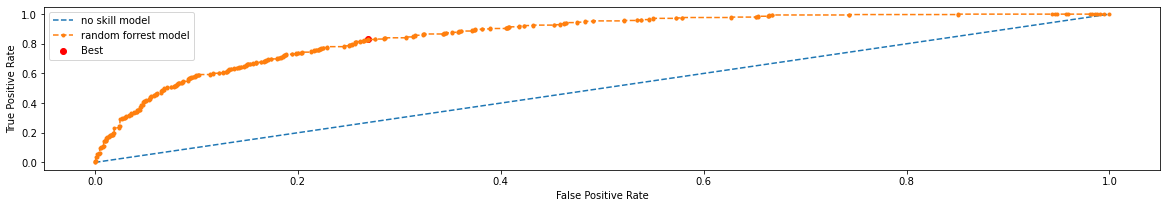

F1 score with optimal treshold 0.6270270270270271
              precision    recall  f1-score   support

           0       0.93      0.73      0.82      1055
           1       0.51      0.83      0.63       351

    accuracy                           0.75      1406
   macro avg       0.72      0.78      0.72      1406
weighted avg       0.82      0.75      0.77      1406



0.694614860259032

0.5620518477661335

0.9090098126672613

0.6270270270270271

0.5052264808362369

0.8262108262108262

In [44]:
#Let's find optimal treshold with which we can improve the model

#Le'ts calc false and true positive rates depending on treshold
fpr, tpr, thresholds = roc_curve(y_val, search.predict_proba(X_val)[:,1])

#Let's find optimal treshold at which model ability to predict 0 and 1 is best balanced.
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='no skill model')
plt.plot(fpr, tpr, marker='.', linestyle='--', label='random forrest model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()


#let's see the result of the model with optimal treshold selected
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

t=0.423801

prob_train=search.predict_proba(X_train)[:,1]
prob_val=search.predict_proba(X_val)[:,1]

print('F1 score with optimal treshold',f1_score(y_val,to_labels(prob_val,t)))
print(classification_report(y_val,to_labels(prob_val,t)))

'Train F1, Precision, Recall'
display(f1_score(y_train,to_labels(prob_train,t)))
display(precision_score(y_train,to_labels(prob_train,t)))
display(recall_score(y_train,to_labels(prob_train,t)))
'Val F1, Precision, Recall'
display(f1_score(y_val,to_labels(prob_val,t)))
display(precision_score(y_val,to_labels(prob_val,t)))
display(recall_score(y_val,to_labels(prob_val,t)))

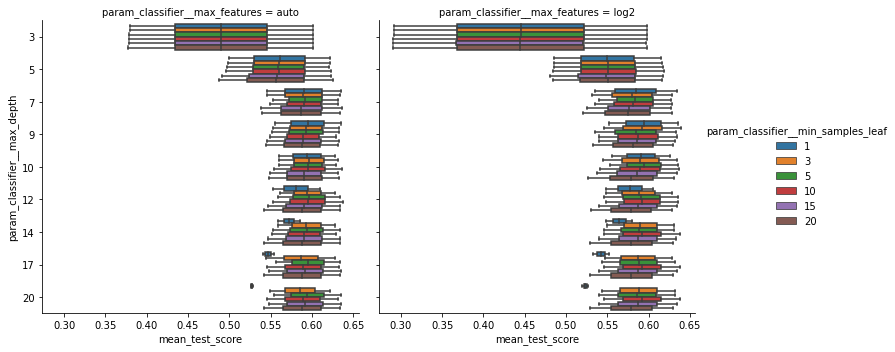

In [16]:
#Lets visualize Gridsearh results
results=pd.DataFrame(search.cv_results_)

#Shows f1 score depending on max depth (y_axis) and min_samples_leaf(color). This needs loop to split other dimension (i.e. max_features, class_weight)
sns.catplot(data=results, x='mean_test_score', y='param_classifier__max_depth',hue='param_classifier__min_samples_leaf',kind="box",col="param_classifier__max_features")

# sns.lineplot(data=results,x='param_classifier__max_depth',y='mean_test_score')

# sns.relplot(
#     data=results,x='param_classifier__max_depth', y='mean_test_score',
#     col='param_classifier__max_features',
#     kind="line"
# )

Lets try using undersampling 

In [29]:
# define model
model = RandomForestClassifier(random_state=44,n_jobs=-1)
# define resampling
under = RandomUnderSampler(sampling_strategy=0.5)

from imblearn.pipeline import Pipeline as imbPipeline
# define pipeline
pipeline = imbPipeline(steps=[('u', under), ('classifier', model)])

Lets train and evaluate our model

Its 0.1624 better on recall than our base model

In [34]:

pipeline.fit(prep_std_onehot.fit_transform(X_train),y_train)

prob_train=pipeline.predict_proba(prep_std_onehot.fit_transform(X_train))[:,1]
prob_val=pipeline.predict_proba(prep_std_onehot.transform(X_val))[:,1]

'Train F1, Precision, Recall'
display(f1_score(y_train,to_labels(prob_train,t)))
display(precision_score(y_train,to_labels(prob_train,t)))
display(recall_score(y_train,to_labels(prob_train,t)))
'Val F1, Precision, Recall'
display(f1_score(y_val,to_labels(prob_val,t)))
display(precision_score(y_val,to_labels(prob_val,t)))
display(recall_score(y_val,to_labels(prob_val,t)))


0.9306766293067662

0.8703416149068323

1.0

0.5969387755102041

0.5404157043879908

0.6666666666666666

Lets find optimal hyperparameters on undersampled pipeline

In [31]:
params_grid= {
    'classifier__max_depth': [None,3,5,7,9,10,12,14,17,20],
    'classifier__class_weight': [None,'balanced'],
    'classifier__max_features': [None,'auto','log2'],
    'classifier__min_samples_leaf': [1,3,5,10,15,20]
}

search_sampled=GridSearchCV(pipeline,params_grid,scoring='f1',n_jobs=-1,verbose=2)

In [32]:
search_sampled.fit(prep_std_onehot.fit_transform(X_train),y_train)

search_sampled.best_params_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(estimator=Pipeline(steps=[('u',
                                        RandomUnderSampler(sampling_strategy=0.5)),
                                       ('classifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=44))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': [None, 'balanced'],
                         'classifier__max_depth': [None, 3, 5, 7, 9, 10, 12, 14,
                                                   17, 20],
                         'classifier__max_features': [None, 'auto', 'log2'],
                         'classifier__min_samples_leaf': [1, 3, 5, 10, 15, 20]},
             scoring='f1', verbose=2)

Let's evaluate model with optimal hyperparameters

Its better on recall by 0.3590



In [35]:
prob_train=search_sampled.predict_proba(prep_std_onehot.fit_transform(X_train))[:,1]
prob_val=search_sampled.predict_proba(prep_std_onehot.transform(X_val))[:,1]

'Train F1, Precision, Recall'
display(f1_score(y_train,to_labels(prob_train,t)))
display(precision_score(y_train,to_labels(prob_train,t)))
display(recall_score(y_train,to_labels(prob_train,t)))
'Val F1, Precision, Recall'
display(f1_score(y_val,to_labels(prob_val,t)))
display(precision_score(y_val,to_labels(prob_val,t)))
display(recall_score(y_val,to_labels(prob_val,t)))

0.6471163245356795

0.5097535934291582

0.8858162355040142

0.6209016393442623

0.4848

0.8632478632478633

Let's find optimal treshold for the undersampled & tuned model

Its 0.3391 better on recall than base model

Best Threshold=0.450807, G-Mean=0.781


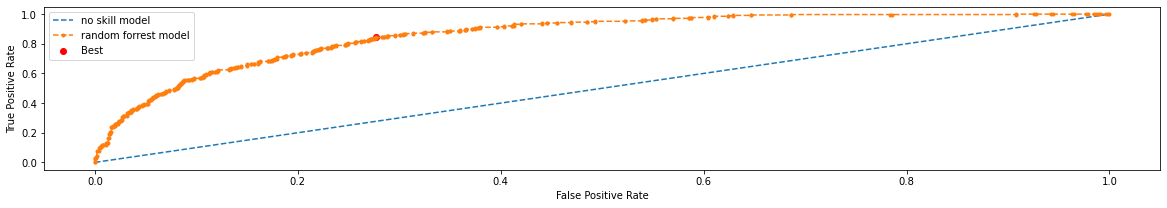

F1 score with optimal treshold 0.630457933972311
              precision    recall  f1-score   support

           0       0.93      0.72      0.81      1055
           1       0.50      0.84      0.63       351

    accuracy                           0.75      1406
   macro avg       0.72      0.78      0.72      1406
weighted avg       0.83      0.75      0.77      1406



0.6551373346897253

0.5284463894967177

0.8617305976806423

0.630457933972311

0.5034013605442177

0.8433048433048433

In [38]:
#Let's find optimal treshold with which we can improve the model

#Le'ts calc false and true positive rates depending on treshold
fpr, tpr, thresholds = roc_curve(y_val, search_sampled.predict_proba(prep_std_onehot.transform(X_val))[:,1])

#Let's find optimal treshold at which model ability to predict 0 and 1 is best balanced.
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='no skill model')
plt.plot(fpr, tpr, marker='.', linestyle='--', label='random forrest model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()


#let's see the result of the model with optimal treshold selected
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

t=0.450807
print('F1 score with optimal treshold',f1_score(y_val,to_labels(prob_val,t)))
print(classification_report(y_val,to_labels(prob_val,t)))

prob_train=search_sampled.predict_proba(prep_std_onehot.fit_transform(X_train))[:,1]
prob_val=search_sampled.predict_proba(prep_std_onehot.transform(X_val))[:,1]

'Train F1, Precision, Recall'
display(f1_score(y_train,to_labels(prob_train,t)))
display(precision_score(y_train,to_labels(prob_train,t)))
display(recall_score(y_train,to_labels(prob_train,t)))
'Val F1, Precision, Recall'
display(f1_score(y_val,to_labels(prob_val,t)))
display(precision_score(y_val,to_labels(prob_val,t)))
display(recall_score(y_val,to_labels(prob_val,t)))

#Lets try finding best hyperparmeters on ordinally encoded X (standards scaler + ordinal)

In [34]:
#Hyperparameters for grid search and instantiation of gridsearch
params_grid= {
    'classifier__max_depth': [None,3,5,7,9,10,12,14,17,20],
    'classifier__class_weight': [None,'balanced'],
    'classifier__max_features': [None,'auto','log2'],
    'classifier__min_samples_leaf': [1,3,5,10,15,20]
}

search_ordinal=GridSearchCV(pipe_ordinal_std,params_grid,scoring='f1',n_jobs=-1,verbose=2)

In [35]:
#Find the optimal hyperparmeters
search_ordinal.fit(X_train,y_train)

#print optimal paramaters
search_ordinal.best_params_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 7,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 10}

Let's evaluate the model

Its 0.3391  better than base model

In [36]:
#See the precision, recall & f1 score for train and val with optimal hyperparameters
'Train F1, Precision, Recall'
display(f1_score(y_train,search_ordinal.predict(X_train)))
display(precision_score(y_train,search_ordinal.predict(X_train)))
display(recall_score(y_train,search_ordinal.predict(X_train)))
'Val F1, Precision, Recall'
display(f1_score(y_val,search_ordinal.predict(X_val)))
display(precision_score(y_val,search_ordinal.predict(X_val)))
display(recall_score(y_val,search_ordinal.predict(X_val)))

0.6767193821257815

0.5757196495619524

0.8206958073148974

0.6373117033603708

0.537109375

0.7834757834757835

Best Threshold=0.475367, G-Mean=0.781


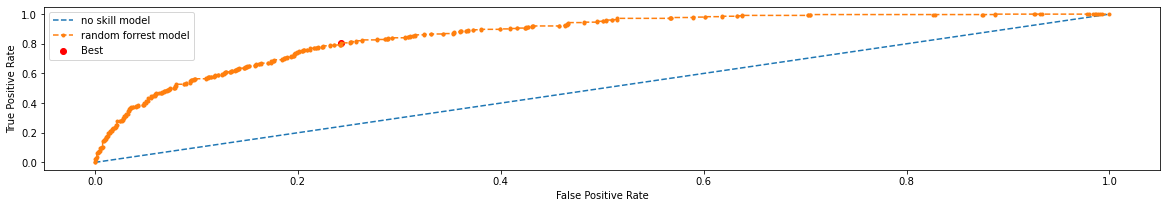

F1 score with optimal treshold 0.6344206974128234
              precision    recall  f1-score   support

           0       0.92      0.76      0.83      1055
           1       0.52      0.80      0.63       351

    accuracy                           0.77      1406
   macro avg       0.72      0.78      0.73      1406
weighted avg       0.82      0.77      0.78      1406



0.6723525230987918

0.5587714116952156

0.8438893844781445

0.6344206974128234

0.5241635687732342

0.8034188034188035

In [38]:
#Let's find optimal treshold with which we can improve the model

#Le'ts calc false and true positive rates depending on treshold
fpr, tpr, thresholds = roc_curve(y_val, search_ordinal.predict_proba(X_val)[:,1])

#Let's find optimal treshold at which model ability to predict 0 and 1 is best balanced.
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='no skill model')
plt.plot(fpr, tpr, marker='.', linestyle='--', label='random forrest model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()


#let's see the result of the model with optimal treshold selected
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

t=0.475367
print('F1 score with optimal treshold',f1_score(y_val,to_labels(search_ordinal.predict_proba(X_val)[:,1],t)))
print(classification_report(y_val,to_labels(search_ordinal.predict_proba(X_val)[:,1],t)))

'Train F1, Precision, Recall'
display(f1_score(y_train,to_labels(search_ordinal.predict_proba(X_train)[:,1],t)))
display(precision_score(y_train,to_labels(search_ordinal.predict_proba(X_train)[:,1],t)))
display(recall_score(y_train,to_labels(search_ordinal.predict_proba(X_train)[:,1],t)))
'Val F1, Precision, Recall'
display(f1_score(y_val,to_labels(search_ordinal.predict_proba(X_val)[:,1],t)))
display(precision_score(y_val,to_labels(search_ordinal.predict_proba(X_val)[:,1],t)))
display(recall_score(y_val,to_labels(search_ordinal.predict_proba(X_val)[:,1],t)))